In [25]:
DATA_PATH = "../data/processed/02_cleaned.pkl"

MLFLOW_TRACKING_URI = "../models/mlruns"
MLFLOW_EXPERIMENT_NAME = "churn_rate_prediction"

LOG_PATH = "../models/temp/"
LOG_DATA_PKL = "data.pkl"
LOG_MODEL_PKL = "model.pkl"
LOG_METRICS_PKL = "metrics.pkl"

In [2]:
# Load packages
import pandas as pd

from pathlib import Path
import os
import pickle

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import mlflow
from mlflow.tracking import MlflowClient

___
## Functions

In [3]:
def calculate_quality(ground_truth, predictions, metric_function, model_name):
    """
    Calculate the quality of the model according to different metric scores
    Input:
        ground_truth: from real observed data
        predictions: the predicted values from the model
        metric_function: the metric score funcrion used to measure performance
    Output:
        A dict of all scores for the given inputs
    """
    quality_score = {}
    quality_score[model_name] = round(metric_function(ground_truth, predictions), 3)
    quality_score = pd.Series(quality_score.values(), index=quality_score.keys())
    
    return quality_score

___
## Intialize

In [4]:
Path(MLFLOW_TRACKING_URI).mkdir(parents=True, exist_ok=True)
Path(LOG_PATH).mkdir(parents=True, exist_ok=True)

___
## Read data

In [34]:
df = pd.read_pickle(DATA_PATH)
df.sample(5)

,seniorcitizen,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
4588,0,0.0,33,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,3.0,95.00,3008.15,0.0
860,0,0.0,26,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,19.80,457.30,0.0
2249,0,0.0,11,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,0.0,1.0,70.50,829.30,0.0
2571,0,1.0,42,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,100.40,4303.65,0.0
3333,0,1.0,12,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,19.35,212.30,0.0


___
## Split data for modeling

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis=1),
                                                    df[['churn']],
                                                    test_size=0.2,
                                                    random_state=42)

In [36]:
print(X_train.shape)
X_train.sample(5)

(5600, 17)


,seniorcitizen,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
34,1,0.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,45.25,45.25
4225,0,0.0,8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.25,158.35
4068,0,1.0,14,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,19.50,272.00
113,1,0.0,37,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,76.50,2868.15
4515,0,0.0,15,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,83.20,1130.00


___
## Intializing MLFLOW

In [37]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient()

In [38]:
try:
    mlflow.create_experiment(MLFLOW_EXPERIMENT_NAME)
except:
    print(f'Experiment "{MLFLOW_EXPERIMENT_NAME}" exists at "{mlflow.get_tracking_uri()}"')

Experiment "churn_rate_prediction" exists at "../models/mlruns"


In [39]:
exp = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
print(exp)

<Experiment: artifact_location='../models/mlruns/0', experiment_id='0', lifecycle_stage='active', name='churn_rate_prediction', tags={}>


___
## Base model; Logistic Regression
**1. without balancing**

In [40]:
clf = make_pipeline(MinMaxScaler(),
                    LogisticRegression())

clf.fit(X_train.values, (y_train.values).reshape(-1,))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])

### Evaluate on training data:

In [41]:
# Evaluate on training set:
predictions = pd.DataFrame(clf.predict(X_train.values),
                          columns=y_train.columns)

train_scores = {score.__name__:calculate_quality(y_train, predictions, score, "LogisticRegression")
                for score in [accuracy_score, precision_score, recall_score, f1_score]}

train_scores = pd.concat(train_scores, axis=1)
train_scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression,0.807,0.657,0.547,0.597


In [42]:
mean_train_score = train_scores.mean()
mean_train_score

accuracy_score     0.807
precision_score    0.657
recall_score       0.547
f1_score           0.597
dtype: float64

### Evaluate on testing data:

In [43]:
# Evaluate on training set:
predictions = pd.DataFrame(clf.predict(X_test.values),
                          columns=y_test.columns)

test_scores = {score.__name__:calculate_quality(y_test, predictions, score, "LogisticRegression")
                for score in [accuracy_score, precision_score, recall_score, f1_score]}

test_scores = pd.concat(test_scores, axis=1)
test_scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression,0.797,0.671,0.495,0.57


In [44]:
mean_test_score = test_scores.mean()
mean_test_score

accuracy_score     0.797
precision_score    0.671
recall_score       0.495
f1_score           0.570
dtype: float64

<AxesSubplot:>

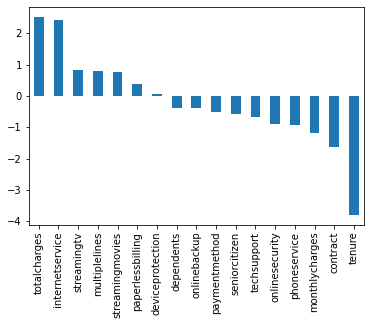

In [68]:
# To get the weights of all the variables
weights = pd.Series(clf.named_steps['logisticregression'].coef_[0],
                 index=X_train.columns.values)
weights.sort_values(ascending = False).plot(kind='bar')

**We can see there are equal weights on services columns; it would be better if we used dimensionality reduction on it**

___
## Now Trying to use resampling:

In [45]:
y_train.value_counts()

churn
0.0      4134
1.0      1466
dtype: int64

In [46]:
sm = SMOTE(random_state=42)
X_train_balance, y_train_balance = sm.fit_resample(X_train, y_train)

In [47]:
y_train.value_counts()

churn
0.0      4134
1.0      1466
dtype: int64

**1. with balancing**

In [49]:
clf_balance = make_pipeline(MinMaxScaler(),
                    LogisticRegression())

clf_balance.fit(X_train_balance.values, (y_train_balance.values).reshape(-1,))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])

### Evaluate on training data:

In [50]:
# Evaluate on training set:
predictions = pd.DataFrame(clf_balance.predict(X_train.values),
                          columns=y_train.columns)

train_scores = {score.__name__:calculate_quality(y_train, predictions, score, "LogisticRegression")
                for score in [accuracy_score, precision_score, recall_score, f1_score]}

train_scores = pd.concat(train_scores, axis=1)
train_scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression,0.748,0.513,0.781,0.619


In [51]:
mean_train_score = train_scores.mean()
mean_train_score

accuracy_score     0.748
precision_score    0.513
recall_score       0.781
f1_score           0.619
dtype: float64

### Evaluate on testing data:

In [52]:
# Evaluate on training set:
predictions = pd.DataFrame(clf_balance.predict(X_test.values),
                          columns=y_test.columns)

test_scores = {score.__name__:calculate_quality(y_test, predictions, score, "LogisticRegression")
                for score in [accuracy_score, precision_score, recall_score, f1_score]}

test_scores = pd.concat(test_scores, axis=1)
test_scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression,0.755,0.534,0.766,0.629


In [53]:
mean_test_score = test_scores.mean()
mean_test_score

accuracy_score     0.755
precision_score    0.534
recall_score       0.766
f1_score           0.629
dtype: float64

___
## Balance doesn't help:
**As we can see balancing the data doesn't help at all. Even it makes the model performs worse**

### Log run

In [54]:
# Data details
data_details = {"data_path": DATA_PATH,
                "training_indices": X_train.index.tolist(),
                "test_indices": X_test.index.tolist(),
                "feature_names": X_train.columns.tolist(),
                "target_names": y_train.columns.tolist()}

with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
    pickle.dump(data_details, output_file)

In [55]:
# Model details
model = {"model_description": "Base Model, Logistic Regression",
         "model_details": str(clf),
         "model_object": clf}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [56]:
# Performance details
regression_metrics = {"train_scores": train_scores,
                      "test_scores": test_scores}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(regression_metrics, output_file)

### Logging

In [57]:
# Start a new run and track
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # log pickle
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics
    for metric, score in mean_test_score.items():
        mlflow.log_metric(metric, score)